In [1]:
#pip install imblearn --user
#pip install shap

In [2]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline  

from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from xgboost.sklearn import XGBRegressor

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import KFold

from sklearn.model_selection import GridSearchCV   
from sklearn.metrics import make_scorer

#import warnings
#warnings.filterwarnings("ignore")

import shap

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score,roc_auc_score


from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from matplotlib.collections import LineCollection

In [3]:
data=pd.read_csv('train_final.csv')
data.head()

,age_range,marital_status,rented,family_size,no_of_children,income_bracket,cust_quantity,cust_other_usage,cust_coupon_usage,camp_type,camp_start_month,camp_end_month,camp_duration,holiday_covered,item_NO.,brand_NO.,brand_type,category,items_quantity,redemption_status
0,46-55,Single,0,1,0,5,105551,167,1,X,5,7,47,Yes,125,2,Established,Grocery,4661,0
1,36-45,Married,0,2,0,3,12143,209,12,X,5,7,47,Yes,3,1,Local,Grocery,86,0
2,46-55,Married,0,2,0,7,1351,457,85,Y,3,4,32,No,67,1,Established,Pharmaceutical,202,0
3,unknown,unknown,unknown,unknown,unknown,unknown,306,120,2,X,5,7,47,Yes,4,1,Established,Grocery,47,0
4,46-55,Married,0,2,0,3,139063,281,10,X,2,4,48,Yes,32,1,Established,Grocery,1610,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78369 entries, 0 to 78368
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age_range          78369 non-null  object
 1   marital_status     78369 non-null  object
 2   rented             78369 non-null  object
 3   family_size        78369 non-null  object
 4   no_of_children     78369 non-null  object
 5   income_bracket     78369 non-null  object
 6   cust_quantity      78369 non-null  int64 
 7   cust_other_usage   78369 non-null  int64 
 8   cust_coupon_usage  78369 non-null  int64 
 9   camp_type          78369 non-null  object
 10  camp_start_month   78369 non-null  int64 
 11  camp_end_month     78369 non-null  int64 
 12  camp_duration      78369 non-null  int64 
 13  holiday_covered    78369 non-null  object
 14  item_NO.           78369 non-null  int64 
 15  brand_NO.          78369 non-null  int64 
 16  brand_type         78369 non-null  objec

In [5]:
features=list(data.columns)
target='redemption_status'
features.remove(target)
X=data[features]
y=data[target]

In [6]:
y.value_counts(normalize=True)

0    0.990698
1    0.009302
Name: redemption_status, dtype: float64

In [7]:
from collections import Counter
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%s, Count=%d, Percentage=%.3f%%' % (k, v, per))

Class=0, Count=77640, Percentage=99.070%
Class=1, Count=729, Percentage=0.930%


In [8]:
# stratified train/test split with an imbalanced dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, shuffle=True, random_state=2022, stratify=y)

In [9]:
train_0, train_1 = len(y_train[y_train == 0]), len(y_train[y_train == 1])
test_0, test_1 = len(y_test[y_test == 0]), len(y_test[y_test == 1])
print('Train:\n\t Class=0, Count=%d, Percentage=%.4f%%, Class=1, Count=%d, Percentage=%.4f%%' % (train_0, train_0/(train_1+train_0)*100, train_1, train_1/(train_1+train_0)*100))
print('Test:\n\t Class=0, Count=%d, Percentage=%.4f%%, Class=1, Count=%d, Percentage=%.4f%%' % (test_0, test_0/(test_1+test_0)*100, test_1, test_1/(test_1+test_0)*100))

Train:
	 Class=0, Count=62112, Percentage=99.0701%, Class=1, Count=583, Percentage=0.9299%
Test:
	 Class=0, Count=15528, Percentage=99.0685%, Class=1, Count=146, Percentage=0.9315%


In [10]:
X_train.reset_index(inplace=True,drop=True)
X_test.reset_index(inplace=True,drop=True)
y_train.reset_index(inplace=True,drop=True)
y_test.reset_index(inplace=True,drop=True)

## Evaluate Models

### Evaluate Machine Learning Algorithms

In [11]:
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import fbeta_score

In [13]:


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

In [14]:
features = [
    'age_range', 'marital_status', 'rented', 'family_size', 'no_of_children',
    'income_bracket', 'cust_quantity', 'cust_other_usage', 'cust_coupon_usage',
    'camp_type', 'camp_start_month', 'camp_end_month', 'camp_duration',
    'holiday_covered', 'item_NO.', 'brand_NO.', 'brand_type', 'category',
    'items_quantity'
]

numeric_features = ['cust_quantity', 'cust_other_usage', 'cust_coupon_usage',
                'camp_duration','item_NO.', 'brand_NO.', 'items_quantity']
categorical_features=list(set(features)-set(numeric_features))
categorical_features

['family_size',
 'holiday_covered',
 'age_range',
 'no_of_children',
 'marital_status',
 'camp_start_month',
 'income_bracket',
 'camp_type',
 'camp_end_month',
 'rented',
 'category',
 'brand_type']

In [15]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline

In [15]:
# calculate f2-measure
def f2_measure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

# evaluate a model
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define the model evaluation metric
    metric = make_scorer(f2_measure)
    # evaluate model     
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

# define models to test
def get_models():
    models, names = list(), list()
    # LR Balanced + Normalization
    numeric_transformer = MinMaxScaler()
    categorical_transformer = OneHotEncoder(handle_unknown="ignore")
    Preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features),
                                                   ("cat", categorical_transformer, categorical_features)], 
                                     remainder='passthrough')
    steps = [('preprocessor', Preprocessor), 
             ('classifier', LogisticRegression(class_weight='balanced',solver='liblinear', random_state=2022, max_iter=1000))]       
    models.append(Pipeline(steps=steps))
    names.append('Balanced-Norm')
    
    # LR Balanced + Standardization
    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown="ignore")
    Preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features),
                                                   ("cat", categorical_transformer, categorical_features)], 
                                     remainder='passthrough')
    steps = [('preprocessor', Preprocessor), 
             ('classifier', LogisticRegression(class_weight='balanced', solver='liblinear', random_state=2022, max_iter=1000))]       
    models.append(Pipeline(steps=steps))
    names.append('Balanced-Std')   
      
    
    return models, names
                                   

>Balanced-Norm 0.160 (0.010)
>Balanced-Std 0.161 (0.010)


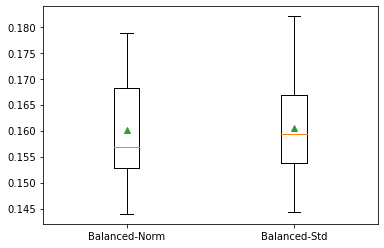

In [16]:
# define models
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
    # evaluate the model and store results
    scores = evaluate_model(X_train, y_train, models[i])
    results.append(scores)
    # summarize and store
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))
# plot the results
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

### Evaluate Balanced Logistic Regression

In [17]:
# calculate f2-measure
def f2_measure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2, average='macro')

# evaluate a model
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define the model evaluation metric
    metric = make_scorer(f2_measure)
    # evaluate model     
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

# define models to test
def get_models():
    models, names = list(), list()
    # LR + Normalization
    numeric_transformer = MinMaxScaler()
    categorical_transformer = OneHotEncoder(handle_unknown="ignore")
    Preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features),
                                                   ("cat", categorical_transformer, categorical_features)], 
                                     remainder='passthrough')
    steps = [('preprocessor', Preprocessor), 
             ('classifier', LogisticRegression(solver='liblinear', random_state=2022, max_iter=1000))]       
    models.append(Pipeline(steps=steps))
    names.append('Norm')
    
    # LR Balanced + Normalization
    numeric_transformer = MinMaxScaler()
    categorical_transformer = OneHotEncoder(handle_unknown="ignore")
    Preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features),
                                                   ("cat", categorical_transformer, categorical_features)], 
                                     remainder='passthrough')
    steps = [('preprocessor', Preprocessor), 
             ('classifier', LogisticRegression(class_weight='balanced',solver='liblinear', random_state=2022, max_iter=1000))]       
    models.append(Pipeline(steps=steps))
    names.append('Balanced-Norm')
    
    # LR + Standardization
    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown="ignore")
    Preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features),
                                                   ("cat", categorical_transformer, categorical_features)], 
                                     remainder='passthrough')
    steps = [('preprocessor', Preprocessor), 
             ('classifier', LogisticRegression(solver='liblinear', random_state=2022, max_iter=1000))]       
    models.append(Pipeline(steps=steps))
    names.append('Std')  
    
    # LR Balanced + Standardization
    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown="ignore")
    Preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features),
                                                   ("cat", categorical_transformer, categorical_features)], 
                                     remainder='passthrough')
    steps = [('preprocessor', Preprocessor), 
             ('classifier', LogisticRegression(class_weight='balanced', solver='liblinear', random_state=2022, max_iter=1000))]       
    models.append(Pipeline(steps=steps))
    names.append('Balanced-Std')   
    
    # LR + Power
    numeric_transformer = Pipeline(steps=[('s1', StandardScaler()),('s2',PowerTransformer())])
    categorical_transformer = OneHotEncoder(handle_unknown="ignore")
    Preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features),
                                                   ("cat", categorical_transformer, categorical_features)], 
                                     remainder='passthrough')
    steps = [('preprocessor', Preprocessor), 
             ('classifier', LogisticRegression(solver='liblinear', random_state=2022, max_iter=1000))]     
    models.append(Pipeline(steps=steps))
    names.append('Power')
    
    # LR Balanced + Power
    numeric_transformer = Pipeline(steps=[('s1', StandardScaler()),('s2',PowerTransformer())])
    categorical_transformer = OneHotEncoder(handle_unknown="ignore")
    Preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features),
                                                   ("cat", categorical_transformer, categorical_features)], 
                                     remainder='passthrough')
    steps = [('preprocessor', Preprocessor), 
             ('classifier', LogisticRegression(class_weight='balanced', solver='liblinear', random_state=2022, max_iter=1000))]     
    models.append(Pipeline(steps=steps))
    names.append('Balanced-Power')
    return models, names
                               

>Norm 0.512 (0.012)
>Balanced-Norm 0.505 (0.006)
>Std 0.515 (0.013)
>Balanced-Std 0.506 (0.006)
>Power 0.503 (0.006)
>Balanced-Power 0.525 (0.006)


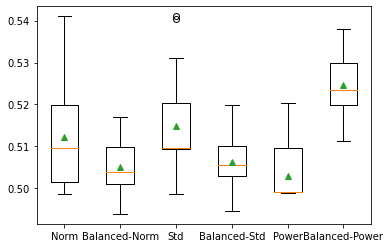

In [18]:
# define models
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
    # evaluate the model and store results
    scores = evaluate_model(X_train, y_train, models[i])
    results.append(scores)
    # summarize and store
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))
# plot the results
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

### Evaluate Machine Learning Algorithms

In [16]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC

In [47]:
# calculate f2-measure
def f2_measure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2, average='macro')

# evaluate a model
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define the model evaluation metric
    metric = make_scorer(f2_measure)
    # evaluate model     
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

# define models to test
def get_models():
    models, names = list(), list()
    # LR
    models.append(LogisticRegression(solver='liblinear'))
    names.append('LR')
    # LDA
    models.append(LinearDiscriminantAnalysis())
    names.append('LDA')
    # NB
    models.append(GaussianNB())
    names.append('NB')
    
    # SVM
    models.append(SVC(gamma='scale'))
    names.append('SVM')
    return models, names

In [ ]:
# define models
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
    # one hot encode categorical, normalize numerical
    numeric_transformer = MinMaxScaler()
    categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse=False)
    Preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features),
                                                   ("cat", categorical_transformer, categorical_features)], 
                                     remainder='passthrough')
    # wrap the model in a pipeline
    steps = [('preprocessor', Preprocessor), 
             ('classifier', models[i])]       
    pipeline = Pipeline(steps=steps)
    # evaluate the model and store results
    scores = evaluate_model(X, y, pipeline)
    results.append(scores)
    # summarize and store
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))
# plot the results
plt.boxplot(results, labels=names, showmeans=True)
plt.show()   
      

>LR 0.511 (0.007)
>LDA 0.580 (0.022)
>NB 0.061 (0.003)


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

In [92]:
# calculate f2-measure
def f2_measure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2, average='macro')

# evaluate a model
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define the model evaluation metric
    metric = make_scorer(f2_measure)
    # evaluate model     
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

# define models to test
def get_models():
    models, names = list(), list()
    # LR
    models.append(LogisticRegression(solver='liblinear'))
    names.append('LR')
    # LDA
    models.append(LinearDiscriminantAnalysis())
    names.append('LDA')
    # Bagging
    models.append(BaggingClassifier(n_estimators=1000))
    names.append('BAG')
    # RF
    models.append(RandomForestClassifier(n_estimators=1000))
    names.append('RF')
    # GBM
    models.append(GradientBoostingClassifier(n_estimators=1000))
    names.append('GBM') 
    # SVM
    models.append(SVC(gamma='scale'))
    names.append('SVM')
    return models, names


>LR 0.511 (0.007)
>LDA 0.580 (0.022)
>BAG 0.567 (0.016)
>RF 0.554 (0.017)
>GBM 0.571 (0.021)
>SVM 0.499 (0.000)


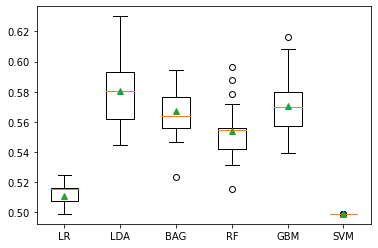

In [94]:
# define models
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
    # one hot encode categorical, normalize numerical
    numeric_transformer = MinMaxScaler()
    categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse=False)
    Preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features),
                                                   ("cat", categorical_transformer, categorical_features)], 
                                     remainder='passthrough')
    # wrap the model in a pipeline
    steps = [('preprocessor', Preprocessor), 
             ('classifier', models[i])]       
    pipeline = Pipeline(steps=steps)
    # evaluate the model and store results
    scores = evaluate_model(X, y, pipeline)
    results.append(scores)
    # summarize and store
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))
# plot the results
plt.boxplot(results, labels=names, showmeans=True)
plt.show()   
      

In [97]:
results_diff_models=results
results_diff_models

[array([0.516094  , 0.49901008, 0.5156599 , 0.49901008, 0.51587618,
        0.50760678, 0.516094  , 0.49901008, 0.516094  , 0.52488606,
        0.516094  , 0.51587618, 0.516094  , 0.516094  , 0.49901008,
        0.51598489, 0.50744603, 0.516094  , 0.50752631, 0.50757535,
        0.51598489, 0.51587618, 0.51576785, 0.49901008, 0.51587618,
        0.50744603, 0.50752631, 0.50760678, 0.516094  , 0.49902291]),
 array([0.57425955, 0.58618009, 0.54466947, 0.56141713, 0.57496221,
        0.57639666, 0.57423498, 0.58992459, 0.60362729, 0.61732055,
        0.59344419, 0.59300554, 0.55814119, 0.58413925, 0.56824655,
        0.5565996 , 0.60241029, 0.58566036, 0.57496221, 0.58579745,
        0.61144792, 0.55404929, 0.60119531, 0.63009025, 0.61049173,
        0.58910495, 0.54745238, 0.55053444, 0.55090846, 0.56292915]),
 array([0.59179831, 0.54711607, 0.57788579, 0.52317555, 0.57880338,
        0.59424223, 0.57044436, 0.5557429 , 0.59424223, 0.57138773,
        0.58555885, 0.55503682, 0.57100961, 

### Evaluate Data Oversampling Algorithms

In [17]:
# data oversampling algorithms on the phoneme imbalanced dataset

from sklearn.ensemble import ExtraTreesClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline

In [98]:
# calculate f2-measure
def f2_measure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2, average='macro')

# evaluate a model
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define the model evaluation metric
    metric = make_scorer(f2_measure)
    # evaluate model     
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

# define oversampling models to test
def get_models():
    models, names = list(), list()
    # RandomOverSampler
    models.append(RandomOverSampler())
    names.append('ROS')
    # SMOTE
    models.append(SMOTE())
    names.append('SMOTE')
    # BorderlineSMOTE
    models.append(BorderlineSMOTE())
    names.append('BLSMOTE')
    # SVMSMOTE
    models.append(SVMSMOTE())
    names.append('SVMSMOTE')
    # ADASYN
    models.append(ADASYN())
    names.append('ADASYN')
    return models, names

>ROS 0.505 (0.006)
>SMOTE 0.511 (0.006)
>BLSMOTE 0.532 (0.007)
>SVMSMOTE 0.564 (0.019)
>ADASYN 0.506 (0.006)


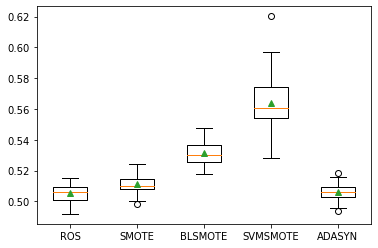

In [82]:
# define models
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
    # define the model
    model = LogisticRegression(class_weight ='balanced', random_state=2022, max_iter=1000)
    # define the pipeline steps
    numeric_transformer = MinMaxScaler()
    categorical_transformer = OneHotEncoder(handle_unknown="ignore")
    Preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features),
                                                   ("cat", categorical_transformer, categorical_features)], 
                                     remainder='passthrough')    
    steps = [('preprocessor', Preprocessor),  
             ('oversampling', models[i]),
             ('classifier', model)]     
    # define the pipeline
    pipeline = Pipeline(steps=steps)
    # evaluate the model and store results
    scores = evaluate_model(X_train, y_train, pipeline)    
    results.append(scores)
    # summarize and store
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))
# plot the results
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

>ROS 0.524 (0.006)
>SMOTE 0.536 (0.006)
>BLSMOTE 0.574 (0.008)
>SVMSMOTE 0.601 (0.011)
>ADASYN 0.530 (0.006)


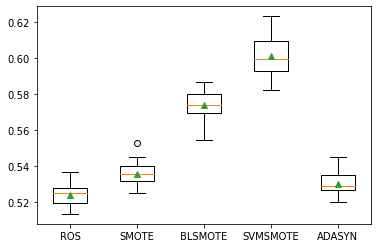

In [83]:
# define models
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
    # define the model
    model = LogisticRegression(class_weight ='balanced', random_state=2022, max_iter=1000)
    # define the pipeline steps    
    numeric_transformer = Pipeline(steps=[('s1', StandardScaler()),('s2',PowerTransformer())])
    categorical_transformer = OneHotEncoder(handle_unknown="ignore")
    Preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features),
                                                   ("cat", categorical_transformer, categorical_features)], 
                                     remainder='passthrough')    
    steps = [('preprocessor', Preprocessor),  
             ('oversampling', models[i]),
             ('classifier', model)]     
    # define the pipeline
    pipeline = Pipeline(steps=steps)
    # evaluate the model and store results
    scores = evaluate_model(X_train, y_train, pipeline)    
    results.append(scores)
    # summarize and store
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))
# plot the results
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

>ROS 0.497 (0.006)
>SMOTE 0.496 (0.007)
>BLSMOTE 0.516 (0.007)
>SVMSMOTE 0.574 (0.023)
>ADASYN 0.494 (0.006)


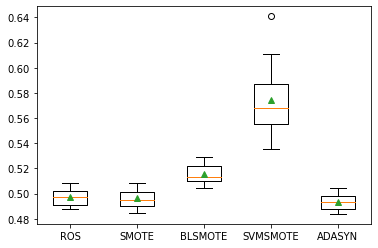

In [101]:
# define models
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
    # define the model
    model = LinearDiscriminantAnalysis()
    # define the pipeline steps    
    numeric_transformer = MinMaxScaler()
    categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse=False)
    Preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features),
                                                   ("cat", categorical_transformer, categorical_features)], 
                                     remainder='passthrough')    
    steps = [('preprocessor', Preprocessor),  
             ('oversampling', models[i]),
             ('classifier', model)]     
    # define the pipeline
    pipeline = Pipeline(steps=steps)
    # evaluate the model and store results
    scores = evaluate_model(X_train, y_train, pipeline)    
    results.append(scores)
    # summarize and store
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))
# plot the results
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

### Evaluate One-Class Algorithms

In [18]:
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor

In [114]:
# calculate f2-measure
def f2_measure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2, average='macro')

# evaluate a model
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define the model evaluation metric
    metric = make_scorer(f2_measure)
    # evaluate model     
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

# define models to test
def get_models():
    models, names = list(), list()
    # One-Class Support Vector Machines
    models.append(OneClassSVM(gamma='scale', nu=0.01))
    names.append('OC')
    # Isolation Forests
    models.append(IsolationForest(contamination=0.01))
    names.append('IF')
    # Minimum Covariance Determinant
    models.append(EllipticEnvelope(contamination=0.01))
    names.append('EE')
    # Local Outlier Factor
    models.append(LocalOutlierFactor(contamination=0.01))
    names.append('LOF')
    return models, names


>OC 0.015 (0.000)
>IF 0.015 (0.000)
>EE 0.014 (0.000)
>LOF nan (nan)


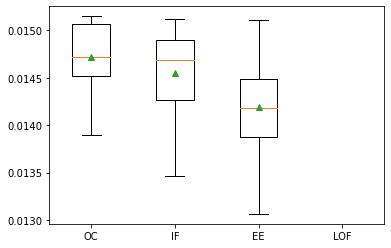

In [115]:
# define models
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
    # one hot encode categorical, normalize numerical
    numeric_transformer = MinMaxScaler()
    categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse=False)
    Preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features),
                                                   ("cat", categorical_transformer, categorical_features)], 
                                     remainder='passthrough')
    # wrap the model in a pipeline
    steps = [('preprocessor', Preprocessor), 
             ('classifier', models[i])]       
    pipeline = Pipeline(steps=steps)
    # evaluate the model and store results
    scores = evaluate_model(X, y, pipeline)
    results.append(scores)
    # summarize and store
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))
# plot the results
plt.boxplot(results, labels=names, showmeans=True)
plt.show() 

### Evaluate SVM Algorithms

In [21]:
#help(fbeta_score)

#### Evaluate SVM kernal

In [27]:
# calculate f2-measure
def f2_measure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2, average='macro')

# evaluate a model
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=1, random_state=1)
    # define the model evaluation metric
    metric = make_scorer(f2_measure)
    # evaluate model     
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

# define models to test
def get_models():
    models, names = list(), list()
    
    # SVM-linear
    models.append(SVC(kernel="linear"))
    names.append('SVM-linear')
    
    # SVM-rbf
    models.append(SVC(kernel="rbf"))
    names.append('SVM-rbf')
    
#     # SVM-poly
#     models.append(SVC(kernel="poly", degree=2))
#     names.append('SVM-linear')
    return models, names

>SVM-linear 0.499 (0.000)
>SVM-rbf 0.499 (0.000)


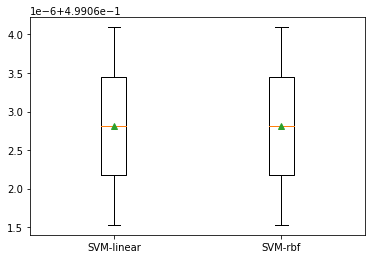

In [28]:
# define models
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
    # one hot encode categorical, normalize numerical
    numeric_transformer = MinMaxScaler()
    categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse=False)
    Preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features),
                                                   ("cat", categorical_transformer, categorical_features)], 
                                     remainder='passthrough')
    # wrap the model in a pipeline
    steps = [('preprocessor', Preprocessor), 
             ('classifier', models[i])]       
    pipeline = Pipeline(steps=steps)
    # evaluate the model and store results
    scores = evaluate_model(X, y, pipeline)
    results.append(scores)
    # summarize and store
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))
# plot the results
plt.boxplot(results, labels=names, showmeans=True)
plt.show()  

#### Evaluate SVM with Oversampling Algorithms

In [29]:
# define oversampling models to test
def get_models():
    models, names = list(), list()
    # RandomOverSampler
    models.append(RandomOverSampler())
    names.append('ROS')
    # SMOTE
    models.append(SMOTE())
    names.append('SMOTE')
    # BorderlineSMOTE
    models.append(BorderlineSMOTE())
    names.append('BLSMOTE')
    # SVMSMOTE
    models.append(SVMSMOTE())
    names.append('SVMSMOTE')
    # ADASYN
    models.append(ADASYN())
    names.append('ADASYN')
    return models, names

>ROS 0.505 (0.012)
>SMOTE 0.513 (0.006)
>BLSMOTE 0.533 (0.006)
>SVMSMOTE 0.577 (0.005)
>ADASYN 0.512 (0.006)


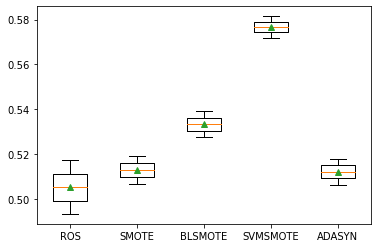

In [30]:
# define models
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
    # define the model
    model = SVC(kernel="linear")
    # define the pipeline steps
    numeric_transformer = MinMaxScaler()
    categorical_transformer = OneHotEncoder(handle_unknown="ignore")
    Preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features),
                                                   ("cat", categorical_transformer, categorical_features)], 
                                     remainder='passthrough')    
    steps = [('preprocessor', Preprocessor),  
             ('oversampling', models[i]),
             ('classifier', model)]     
    # define the pipeline
    pipeline = Pipeline(steps=steps)
    # evaluate the model and store results
    scores = evaluate_model(X_train, y_train, pipeline)    
    results.append(scores)
    # summarize and store
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))
# plot the results
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

#### Evaluate SVM with Cost-sentitive Algorithms

In [31]:
# define oversampling models to test
def get_models():
    models, names = list(), list()
    
    # SVM + balanced 
    models.append(SVC(kernel="linear", class_weight="balanced"))
    names.append('SVM+balanced')
    
    # SVM + 1:9 
    models.append(SVC(kernel="linear", class_weight={0:0.90,1:0.10}))
    names.append('SVM+1:9')
    
    # SVM + 2:8
    models.append(SVC(kernel="linear", class_weight={0:0.80,1:0.20}))
    names.append('SVM+2:8')
    
    return models, names

>SVM+balanced 0.501 (0.001)
>SVM+1:9 0.499 (0.000)
>SVM+2:8 0.499 (0.000)


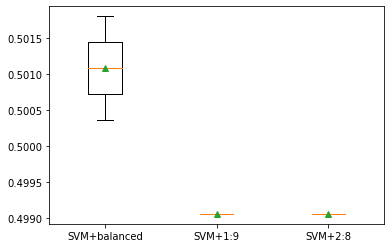

In [32]:
# define models
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
    # one hot encode categorical, normalize numerical
    numeric_transformer = MinMaxScaler()
    categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse=False)
    Preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features),
                                                   ("cat", categorical_transformer, categorical_features)], 
                                     remainder='passthrough')
    # wrap the model in a pipeline
    steps = [('preprocessor', Preprocessor), 
             ('classifier', models[i])]       
    pipeline = Pipeline(steps=steps)
    # evaluate the model and store results
    scores = evaluate_model(X, y, pipeline)
    results.append(scores)
    # summarize and store
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))
# plot the results
plt.boxplot(results, labels=names, showmeans=True)
plt.show() 

#### Evaluate SVM with hyperparameter tuning

In [33]:
# define oversampling models to test
def get_models():
    models, names = list(), list()
    
    # SVM + balanced + C0.1
    models.append(SVC(kernel="linear", class_weight="balanced", C=0.1))
    names.append('SVM+C0.1')
    
    # SVM + balanced + C1
    models.append(SVC(kernel="linear", class_weight="balanced", C=1))
    names.append('SVM+C1')
    
    return models, names

>SVM+C0.1 0.494 (0.002)
>SVM+C1 0.501 (0.001)


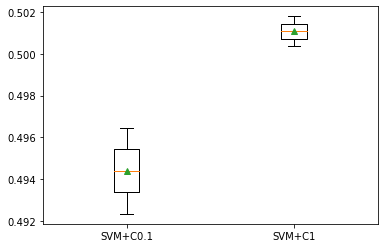

In [34]:
# define models
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
    # one hot encode categorical, normalize numerical
    numeric_transformer = MinMaxScaler()
    categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse=False)
    Preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features),
                                                   ("cat", categorical_transformer, categorical_features)], 
                                     remainder='passthrough')
    # wrap the model in a pipeline
    steps = [('preprocessor', Preprocessor), 
             ('classifier', models[i])]       
    pipeline = Pipeline(steps=steps)
    # evaluate the model and store results
    scores = evaluate_model(X, y, pipeline)
    results.append(scores)
    # summarize and store
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))
# plot the results
plt.boxplot(results, labels=names, showmeans=True)
plt.show() 

### Model Persistence

In [49]:
final_numeric_features = ['cust_quantity', 
                    'cust_other_usage', 
                    'cust_coupon_usage',
                    'camp_duration',
                    'item_NO.', 
                    'brand_NO.', 
                    'items_quantity']
final_X_train = X_train[final_numeric_features]
final_X_train.head()

,cust_quantity,cust_other_usage,cust_coupon_usage,camp_duration,item_NO.,brand_NO.,items_quantity
0,452,128,2,47,16,1,533
1,1135,480,2,48,1,1,56
2,193459,712,11,48,4,1,143
3,11226,1087,227,61,66,1,2605
4,40633,912,44,40,4,1,27


In [50]:
smote = SVMSMOTE(random_state=2022)
final_X_train_2, y_train_2 = smote.fit_resample(final_X_train, y_train)
steps = [('scaler', MinMaxScaler()),
         ('classifier', SVC(kernel="linear"))] 
final_model = Pipeline(steps=steps)
final_model.fit(final_X_train_2, y_train_2)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier', SVC(kernel='linear'))])

In [42]:
import joblib

In [51]:
joblib.dump(final_model, 'final_model.pkl')
list(final_X_train.columns)
joblib.dump(list(final_X_train.columns), 'col_names.pkl')
new_columns = joblib.load('col_names.pkl')

In [52]:
loaded_model = joblib.load('final_model.pkl')
loaded_model.predict([[452, 128, 2, 47, 16, 1, 533]])

X does not have valid feature names, but MinMaxScaler was fitted with feature names


array([0], dtype=int64)